# Load and process LGA Offences.xlsx

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import zipfile

df_lga = None

# Unzip dataset file and load to a dataframe
with zipfile.ZipFile("Data/LGA Offences.xlsx.zip") as z:
    with z.open("LGA Offences.xlsx") as f:
        df_lga = pd.read_excel(f, sheet_name="Table 02")

df_lga.head()

,Year,Year ending,Police Service Area,Local Government Area,Offence Division,Offence Subdivision,Offence Subgroup,Offence Count,"PSA Rate per 100,000 population","LGA Rate per 100,000 population"
0,2023,December,Ballarat,Ballarat,A Crimes against the person,A10 Homicide and related offences,A10 Homicide and related offences,2,1.591737,1.695556
1,2023,December,Ballarat,Ballarat,A Crimes against the person,A20 Assault and related offences,A211 FV Serious assault,131,104.258792,111.058912
2,2023,December,Ballarat,Ballarat,A Crimes against the person,A20 Assault and related offences,A212 Non-FV Serious assault,147,116.992690,124.623359
3,2023,December,Ballarat,Ballarat,A Crimes against the person,A20 Assault and related offences,"A22 Assault police, emergency services or othe...",35,27.855402,29.672228
4,2023,December,Ballarat,Ballarat,A Crimes against the person,A20 Assault and related offences,A231 FV Common assault,258,205.334110,218.726712


In [2]:
df_lga.shape

(53000, 10)

In [3]:
# Table 2 Offence Subgroup:
# Some subgroups in C, D and F Division:
# C: 'C31 Drug use', 'C32 Drug possession', 'C99 Other drug offences'
# D: 'D22 Drunk and disorderly in public'
# F: 'F11 Drink driving', 'F12 Drug driving', 'F33 Liquor and tobacco licensing offences'
# Total 3 Divisions, 7 Subgroups
# Drug-related: C31, C32, C99, F12
# Alcohol-related: D22, F11, F33

drug_subgroup_list = ['C31 Drug use', 'C32 Drug possession', 'C99 Other drug offences', 'F12 Drug driving']
alcohol_subgroup_list = ['D22 Drunk and disorderly in public','F11 Drink driving', 'F33 Liquor and tobacco licensing offences']
offence_count_columns = ["Year", "Local Government Area", "Offence Subgroup", "Offence Count"]
offence_df = df_lga[offence_count_columns]

# The LGA groupings were defnied in EGM dataset
lga_mapping = {
    "WHITTLESEA": ["Whittlesea", "Nillumbik"],
    "NORTHERN GRAMPIANS": ["Ararat", 'Northern Grampians'],
    "GREATER GEELONG": ["Queenscliffe", "Greater Geelong"],
    "COLAC-OTWAY": ["Corangamite", "Colac-Otway"],
    "MOORABOOL": ["Hepburn", "Moorabool"],
    "CENTRAL GOLDFIELDS": ["Central Goldfields", "Mount Alexander"],
    "MITCHELL": ["Mansfield", "Murrindindi", "Mitchell"],
    "ALPINE": ["Towong", "Alpine"],
    "BENALLA": ["Moira", "Strathbogie", "Benalla"],
    "CAMPASPE": ["Gannawarra", "Campaspe"],
    "GLENELG": ["Glenelg", "Southern Grampians"]
}

# 9 missing LGAs from EGM dataset
rows_to_remove = ["Buloke", "Golden Plains", "Hindmarsh", "Indigo", "Loddon", "Moyne", "Pyrenees", "West Wimmera", "Yarriambiack"]

def preprocess_df(subgroup_list, lga_mapping, rows_to_remove):
    new_offence_df = offence_df[offence_df["Offence Subgroup"].isin(subgroup_list)].drop("Offence Subgroup",axis = 1)
    old_to_new = {old_lga: new_lga for new_lga, old_lgas in lga_mapping.items() for old_lga in old_lgas}

    # Map old LGAs to new LGAs
    new_offence_df['Local Government Area'] = new_offence_df['Local Government Area'].replace(old_to_new)

    # Group by 'Year' and 'LGA' and sum the fields
    new_offence_df_combined = new_offence_df.groupby(['Year', 'Local Government Area'], as_index=False).sum(numeric_only=True)
    new_offence_df_pivot = new_offence_df_combined.pivot(index='Local Government Area', columns='Year', values= "Offence Count").fillna(0)
    # Remove unnecessary years and LGAs
    new_offence_df_pivot.drop(columns = [2021,2022,2023], inplace = True)
    new_offence_df_pivot.drop(index=rows_to_remove, inplace = True)
    return new_offence_df_pivot

drug_offence_df = preprocess_df(drug_subgroup_list, lga_mapping, rows_to_remove)
alcohol_offence_df = preprocess_df(alcohol_subgroup_list, lga_mapping, rows_to_remove)


In [4]:
drug_offence_df.head()

Year,2014,2015,2016,2017,2018,2019,2020
Local Government Area,,,,,,,
ALPINE,30,37,29,26,45,37,30
BENALLA,201,187,173,184,153,241,250
Ballarat,431,369,384,289,341,341,315
Banyule,275,364,373,311,425,515,702
Bass Coast,104,167,92,95,103,102,102


In [5]:
alcohol_offence_df.head()

Year,2014,2015,2016,2017,2018,2019,2020
Local Government Area,,,,,,,
ALPINE,20.0,25.0,14.0,12.0,11.0,13.0,17.0
BENALLA,42.0,38.0,40.0,46.0,41.0,33.0,21.0
Ballarat,296.0,161.0,144.0,131.0,111.0,75.0,60.0
Banyule,75.0,54.0,48.0,50.0,49.0,25.0,18.0
Bass Coast,65.0,54.0,37.0,43.0,34.0,29.0,31.0


## Data Exploration

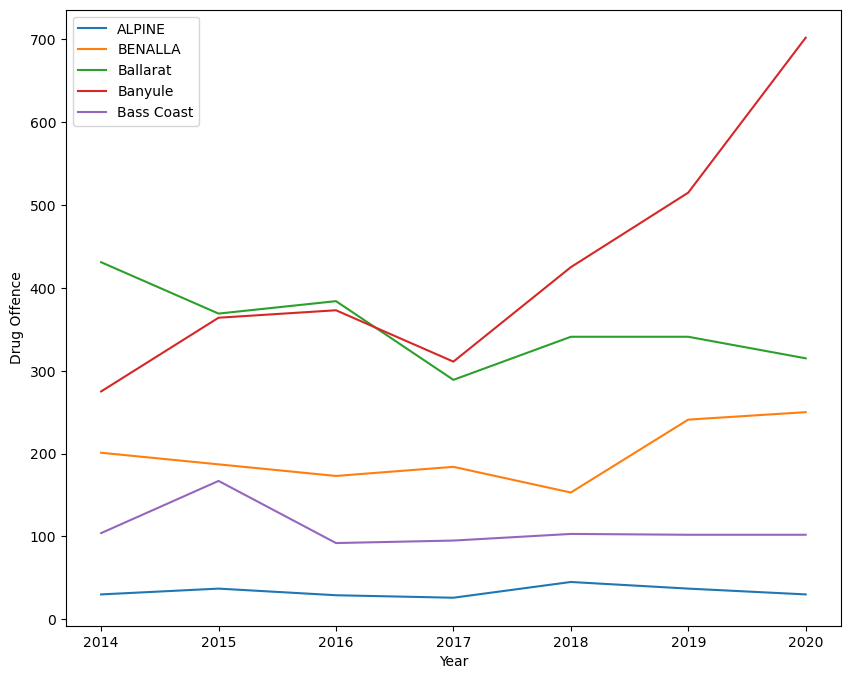

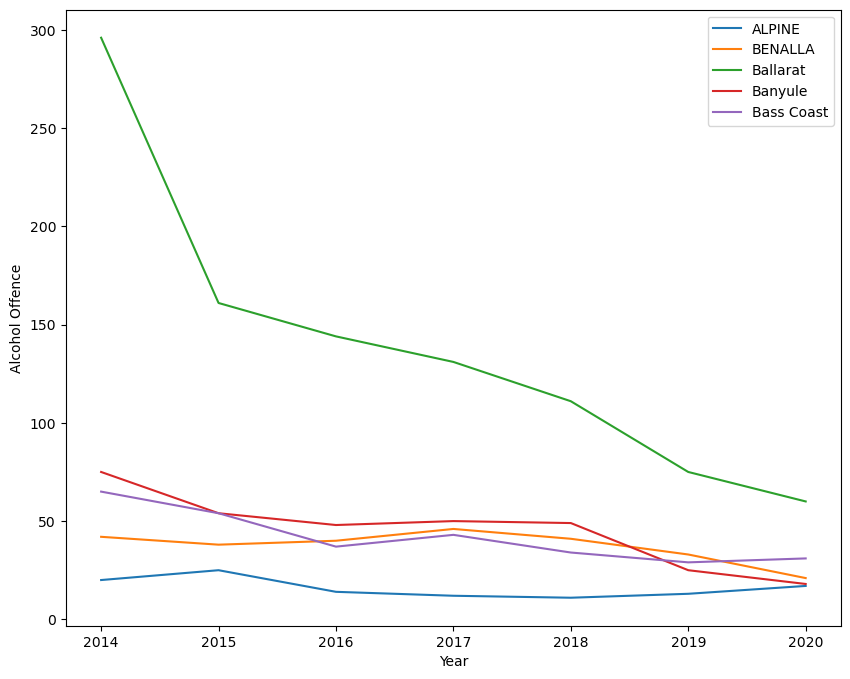

In [6]:
# Define a function to plot line charts for the first n Local Government Areas
def line_plot(df, n, y_label):
    """
    Plot a line chart for the first n rows of the dataframe.
    
    Parameters:
    df : DataFrame - contains the data to be plotted
    n : int - number of rows to plot
    y_label : str - label for the y-axis
    
    Each line represents a Local Government Area, with years on the x-axis 
    and the specified label values on the y-axis.
    """
    plt.figure(figsize=(10, 8))
    x = ["20" + str(i) for i in range (14,21)]
    y = [df.iloc[i] for i in range (n)]
    for i in range (n):
        plt.plot(x, y[i], label=df.index[i])
    plt.xlabel('Year')
    plt.ylabel(y_label)
    plt.legend()
    
# Plot line charts for drug offences and alcohol-related offences    
line_plot(drug_offence_df, 5, "Drug Offence")
line_plot(alcohol_offence_df, 5, "Alcohol Offence")

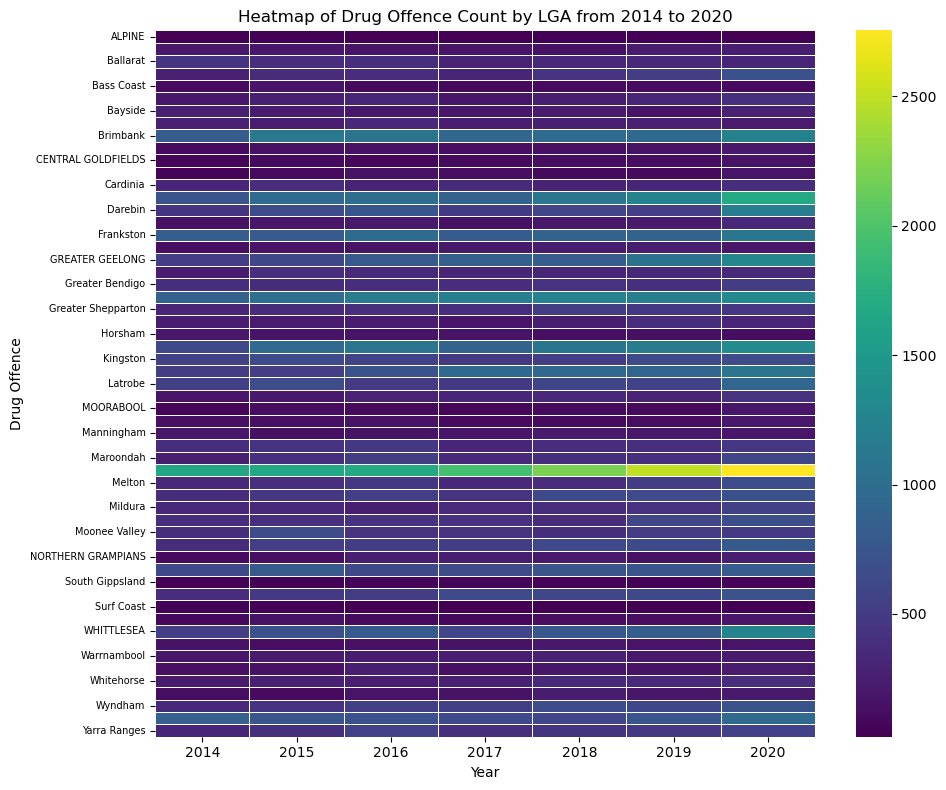

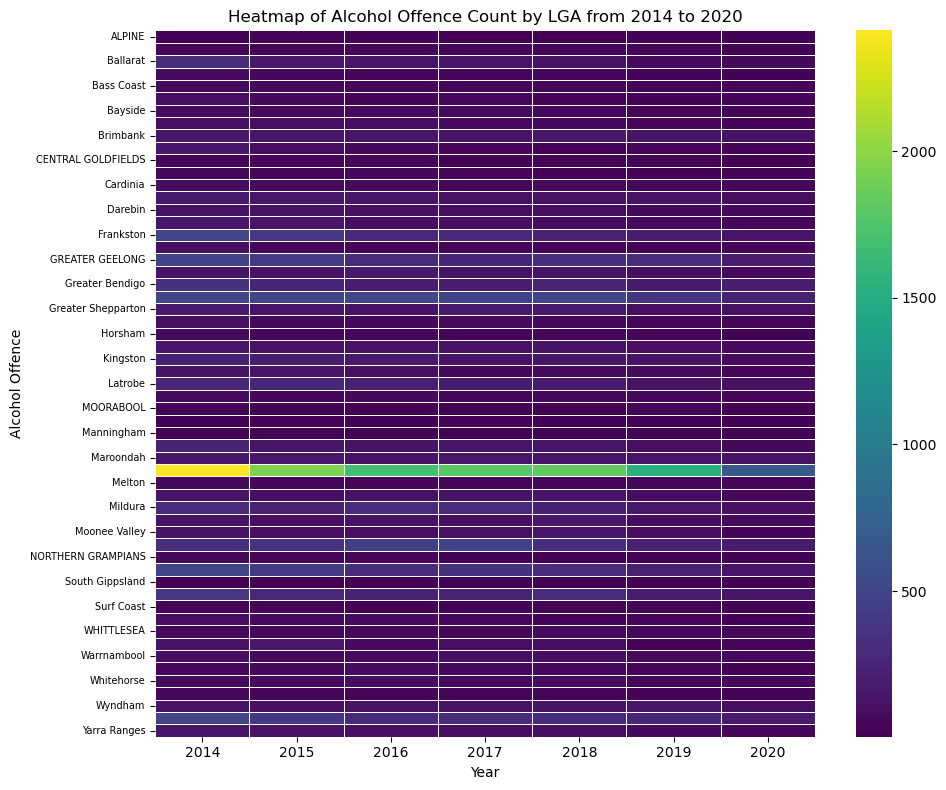

In [7]:
def heat_plot(df, y_label):
    """
    Create a heatmap to visualize the crime counts for Local Government Areas (LGAs) from 2014 to 2020
    
    Parameters:
    df : DataFrame - contains the data to be plotted
    y_label : str - label for the y-axis
    """
    plt.figure(figsize=(10, 8))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df, cmap='viridis', linewidths=0.5, annot=False, fmt=".0f")

    # Add titles and labels as needed
    plt.title('Heatmap of '+ y_label + ' Count by LGA from 2014 to 2020')
    plt.xlabel('Year')
    plt.ylabel(y_label)
    plt.yticks(fontsize=7) 

    # Show the plot
    plt.tight_layout()

# Plot heatmaps for drug offences and alcohol-related offences
heat_plot(drug_offence_df, "Drug Offence")
heat_plot(alcohol_offence_df, "Alcohol Offence")

# Load and process EGM.csv

In [8]:
egm_df = None

# Unzip dataset file and load to a dataframe
with zipfile.ZipFile("Data/EGM.csv.zip") as z:
    with z.open("EGM.csv") as f:
        egm_df = pd.read_csv(f)

egm_df.head()

,LGA Name,Region,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,CITY OF WHITTLESEA,M,1.095429e+08,1.115836e+08,1.010001e+08,1.035006e+08,1.091612e+08,1.116516e+08,1.152932e+08,1.184756e+08,1.207063e+08,91066518.95
1,SHIRE OF NORTHERN GRAMPIANS,C,1.071793e+07,1.121941e+07,1.014142e+07,1.035065e+07,1.003788e+07,9.050693e+06,9.105582e+06,9.720508e+06,9.200584e+06,7004272.36
2,CITY OF GREATER GEELONG,C,1.184686e+08,1.183161e+08,1.097196e+08,1.116281e+08,1.130210e+08,1.132050e+08,1.154188e+08,1.188324e+08,1.203854e+08,89137264.73
3,SHIRE OF COLAC-OTWAY,C,1.105642e+07,1.091608e+07,1.019461e+07,1.007489e+07,1.026330e+07,1.016289e+07,1.023095e+07,1.024279e+07,1.075162e+07,8316806.76
4,SHIRE OF MOORABOOL,C,1.083741e+07,1.116534e+07,1.054645e+07,1.030988e+07,1.057564e+07,1.061337e+07,1.139579e+07,1.196206e+07,1.234074e+07,9631820.68


In [9]:
# Define columns to be removed from the dataframe
columns_to_drop = ["Region", "2011", "2012", "2013"]

# Function to extract the actual LGA name from the full name
def filter_lga_name(full_name):
    words = full_name.split()
    try:
        i = words.index("of")
    except ValueError:
        i = words.index("OF")
    return " ".join(words[i+1:])

# Process the EGM dataframe
# Select first 57 rows and drop specified columns
egm_df = egm_df.head(57).drop(columns= columns_to_drop)

# Apply the filter_lga_name function to clean up LGA names
egm_df["LGA Name"] = egm_df["LGA Name"].apply(filter_lga_name)

# Replace 'Moreland' with 'Merri-bek' 
egm_df['LGA Name'] = egm_df['LGA Name'].apply(lambda x: 'Merri-bek' if x == 'Moreland' else x)

# Sort the dataframe by LGA Name
egm_df.sort_values(by= "LGA Name", inplace= True)

# Set 'LGA Name' as the index and rename it to 'Local Government Area'
egm_df.set_index('LGA Name', inplace=True)
egm_df.index.name = 'Local Government Area'

egm_df.head()

,2014,2015,2016,2017,2018,2019,2020
Local Government Area,,,,,,,
ALPINE,3119936.04,3120455.72,2517169.50,2571123.72,2457035.73,2304602.04,1892293.33
BENALLA,10150100.66,10059504.85,10804029.59,10078993.20,10824258.95,11077898.86,8887679.38
Ballarat,53642391.94,53623993.63,54611247.32,54568804.35,55763965.38,57540687.41,43713216.26
Banyule,55019402.31,54512648.72,55979946.78,55820854.07,58536906.89,57758108.75,42485587.54
Bass Coast,15087373.60,15851964.94,16321155.47,16126066.61,17675542.30,17616911.38,13044199.82


## Data Exploration

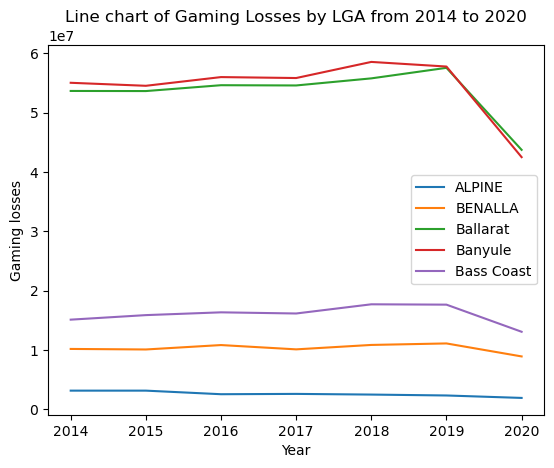

In [10]:
# Function to plot the EGM losses of the first n LGAs
def line_plot(df, n):
    # Create x-axis labels for years 2014 to 2020
    x = ["20" + str(i) for i in range(14, 21)]
    
    # Extract the first n rows of data
    y = [df.iloc[i] for i in range(n)]
    
    # Plot a line for each LGA
    for i in range(n):
        plt.plot(x, y[i], label=df.index[i])
    
    # Set labels and title
    plt.xlabel('Year')
    plt.ylabel("Gaming losses")
    plt.title('Line chart of Gaming Losses by LGA from 2014 to 2020')
    
    # Add legend
    plt.legend()

# Call the function to plot the first 5 LGAs
line_plot(egm_df, 5)

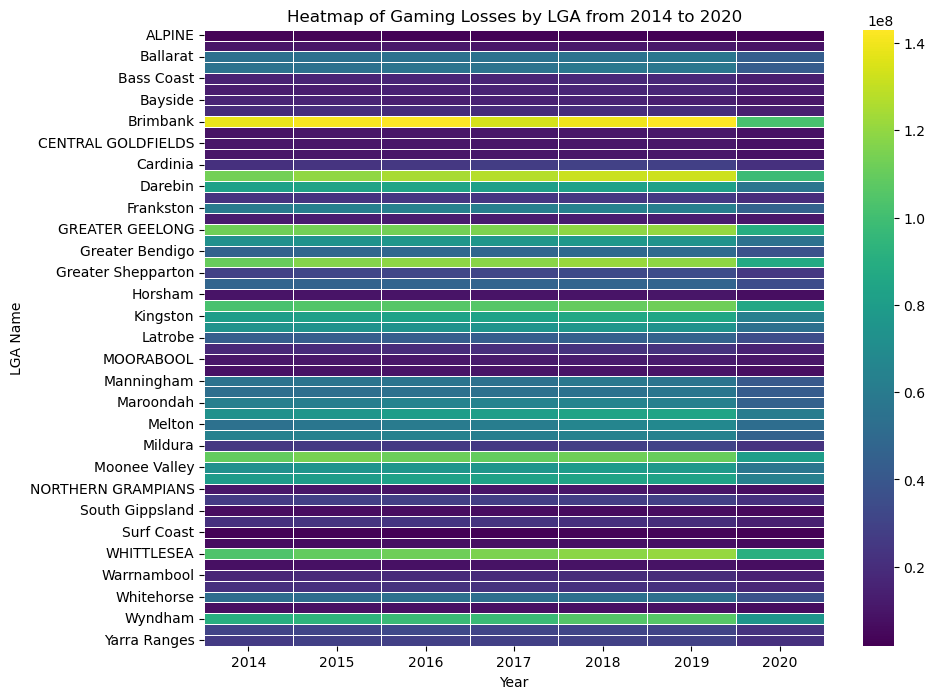

In [11]:
def heat_plot(data):
    # Ensure all data is in float format for consistent plotting
    data = data.astype(float)

    # Create a new figure with specified size
    plt.figure(figsize=(10, 8))

    # Generate the heatmap
    # - data: the input DataFrame
    # - cmap: color scheme ('viridis' is a popular choice for continuous data)
    # - linewidths: width of lines between cells
    # - annot: whether to display values in each cell (False in this case)
    # - fmt: format string for cell values (not used here due to annot=False)
    sns.heatmap(data, cmap='viridis', linewidths=.5, annot=False, fmt=".0f")

    # Set the title of the plot
    plt.title('Heatmap of Gaming Losses by LGA from 2014 to 2020')
    
    # Label the x-axis
    plt.xlabel('Year')
    
    # Label the y-axis
    plt.ylabel('LGA Name')

# Call the function with the egm_df DataFrame
heat_plot(egm_df)

# **Analysis**

In [12]:
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import pearsonr

# Define columns to sum (years 2014 to 2020)
columns_to_sum = [str(i) for i in range(2014, 2021)]

# Convert column names to strings for consistency
egm_df.columns = egm_df.columns.astype(str)
drug_offence_df.columns = drug_offence_df.columns.astype(str)
alcohol_offence_df.columns = alcohol_offence_df.columns.astype(str)

# Calculate sum of values for each LGA across all years
egm_df['Sum'] = egm_df[columns_to_sum].sum(axis=1)
drug_offence_df['Sum'] = drug_offence_df[columns_to_sum].sum(axis=1)
alcohol_offence_df['Sum'] = alcohol_offence_df[columns_to_sum].sum(axis=1)

# Display the first few rows of the drug offence dataframe
drug_offence_df.head()

Year,2014,2015,2016,2017,2018,2019,2020,Sum
Local Government Area,,,,,,,,
ALPINE,30,37,29,26,45,37,30,234
BENALLA,201,187,173,184,153,241,250,1389
Ballarat,431,369,384,289,341,341,315,2470
Banyule,275,364,373,311,425,515,702,2965
Bass Coast,104,167,92,95,103,102,102,765


In [13]:
alcohol_offence_df.head()

Year,2014,2015,2016,2017,2018,2019,2020,Sum
Local Government Area,,,,,,,,
ALPINE,20.0,25.0,14.0,12.0,11.0,13.0,17.0,112.0
BENALLA,42.0,38.0,40.0,46.0,41.0,33.0,21.0,261.0
Ballarat,296.0,161.0,144.0,131.0,111.0,75.0,60.0,978.0
Banyule,75.0,54.0,48.0,50.0,49.0,25.0,18.0,319.0
Bass Coast,65.0,54.0,37.0,43.0,34.0,29.0,31.0,293.0


In [14]:
# Combine drug and alcohol offence data
drug_and_alcohol_df = drug_offence_df + alcohol_offence_df
drug_and_alcohol_df.head()

Year,2014,2015,2016,2017,2018,2019,2020,Sum
Local Government Area,,,,,,,,
ALPINE,50.0,62.0,43.0,38.0,56.0,50.0,47.0,346.0
BENALLA,243.0,225.0,213.0,230.0,194.0,274.0,271.0,1650.0
Ballarat,727.0,530.0,528.0,420.0,452.0,416.0,375.0,3448.0
Banyule,350.0,418.0,421.0,361.0,474.0,540.0,720.0,3284.0
Bass Coast,169.0,221.0,129.0,138.0,137.0,131.0,133.0,1058.0


EGM - Drug Pearson Correlation: 0.725
EGM - Drug Mutual Information: 0.749

EGM - Alcohol Pearson Correlation: 0.293
EGM - Alcohol Mutual Information: 0.319

EGM - Drug_and_Alcohol Pearson Correlation: 0.587
EGM - Drug_and_Alcohol Mutual Information: 0.697



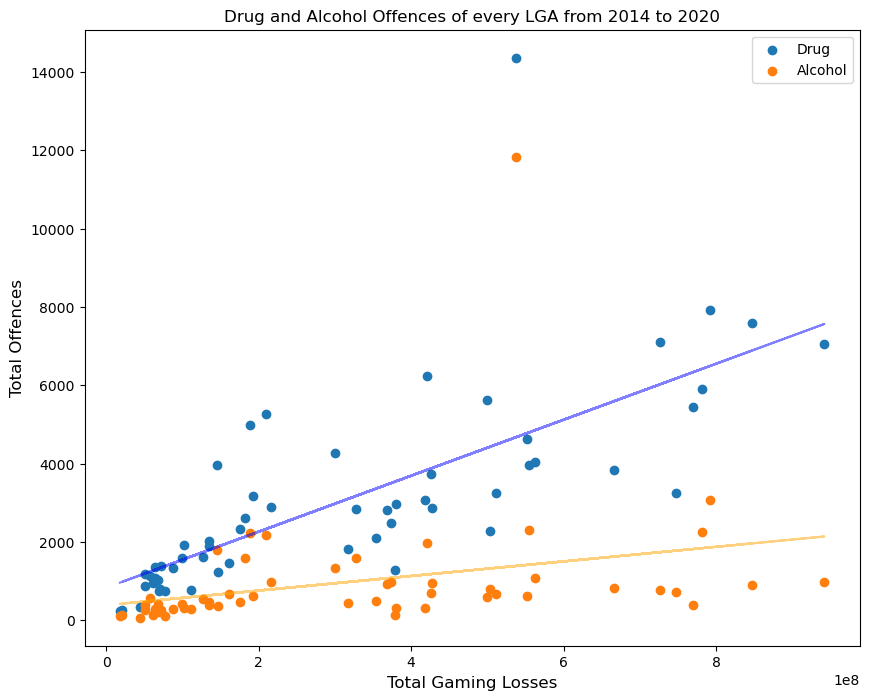

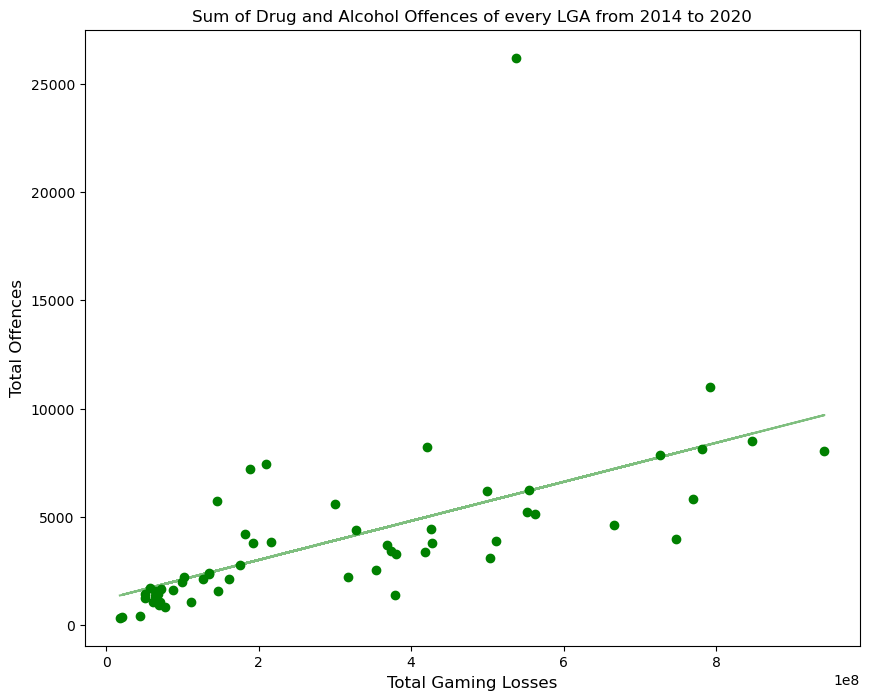

In [15]:
def sum_scatter():
    # Plot the drug and alcohol offences separately
    plt.figure(figsize=(10, 8))

    # Plot the drug offences
    plt.scatter(list(egm_df["Sum"]), list(drug_offence_df["Sum"]), label="Drug")
    slope, intercept = np.polyfit(egm_df["Sum"], drug_offence_df["Sum"], 1)
    # Generate y values for the line of best fit
    line_of_best_fit = slope * egm_df["Sum"] + intercept
    # Plot the line of best fit
    plt.plot(egm_df["Sum"], line_of_best_fit, color='blue', alpha = 0.5)
    
    # Plot the alcohol offences
    plt.scatter(list(egm_df["Sum"]), list(alcohol_offence_df["Sum"]), label = "Alcohol")
    slope, intercept = np.polyfit(egm_df["Sum"], alcohol_offence_df["Sum"], 1)
    # Generate y values for the line of best fit
    line_of_best_fit = slope * egm_df["Sum"] + intercept
    # Plot the line of best fit
    plt.plot(egm_df["Sum"], line_of_best_fit, color='orange', alpha = 0.5)
    
    # Set labels and title
    plt.xlabel('Total Gaming Losses', fontsize=12)
    plt.ylabel('Total Offences', fontsize=12)
    plt.title("Drug and Alcohol Offences of every LGA from 2014 to 2020")
    plt.legend()

    # Plot the total drug and alcohol offences
    plt.figure(figsize=(10, 8))
    plt.scatter(list(egm_df["Sum"]), list(drug_and_alcohol_df["Sum"]), color = "green")
    slope, intercept = np.polyfit(egm_df["Sum"], drug_and_alcohol_df["Sum"], 1)
    # Generate y values for the line of best fit
    line_of_best_fit = slope * egm_df["Sum"] + intercept
    # Plot the line of best fit
    plt.plot(egm_df["Sum"], line_of_best_fit, color = "green", alpha = 0.5)

    # Set labels and title
    plt.xlabel('Total Gaming Losses', fontsize=12)
    plt.ylabel('Total Offences', fontsize=12)
    plt.title("Sum of Drug and Alcohol Offences of every LGA from 2014 to 2020")

# Call the function to plot the scatter plot
sum_scatter()

# Calculate and print correlations and mutual information

# EGM - Drug Correlation
print(f'EGM - Drug Pearson Correlation: {egm_df["Sum"].corr(drug_offence_df["Sum"]):.3f}') # = 0.725 strong positive linear relationship
print(f'EGM - Drug Mutual Information: {mutual_info_regression(egm_df["Sum"].values.reshape(-1, 1),drug_offence_df["Sum"], discrete_features=False)[0]:.3f}\n') # = 0.749 meaningful amount of shared information

# EGM - Alcohol Correlation
print(f'EGM - Alcohol Pearson Correlation: {egm_df["Sum"].corr(alcohol_offence_df["Sum"]):.3f}') # = 0.293 weak positive linear relationship
print(f'EGM - Alcohol Mutual Information: {mutual_info_regression(egm_df["Sum"].values.reshape(-1, 1), alcohol_offence_df["Sum"], discrete_features=False)[0]:.3f}\n') # = 0.319  not as much meaningful

# EGM - Total_Drug_And_Alcohol Correlation
print(f'EGM - Drug_and_Alcohol Pearson Correlation: {egm_df["Sum"].corr(drug_and_alcohol_df["Sum"]):.3f}') #  = 0.587 strong positive linear relationship
print(f'EGM - Drug_and_Alcohol Mutual Information: {mutual_info_regression(egm_df["Sum"].values.reshape(-1, 1), drug_and_alcohol_df["Sum"], discrete_features=False)[0]:.3f}\n') # = 0.319  not as much meaningful


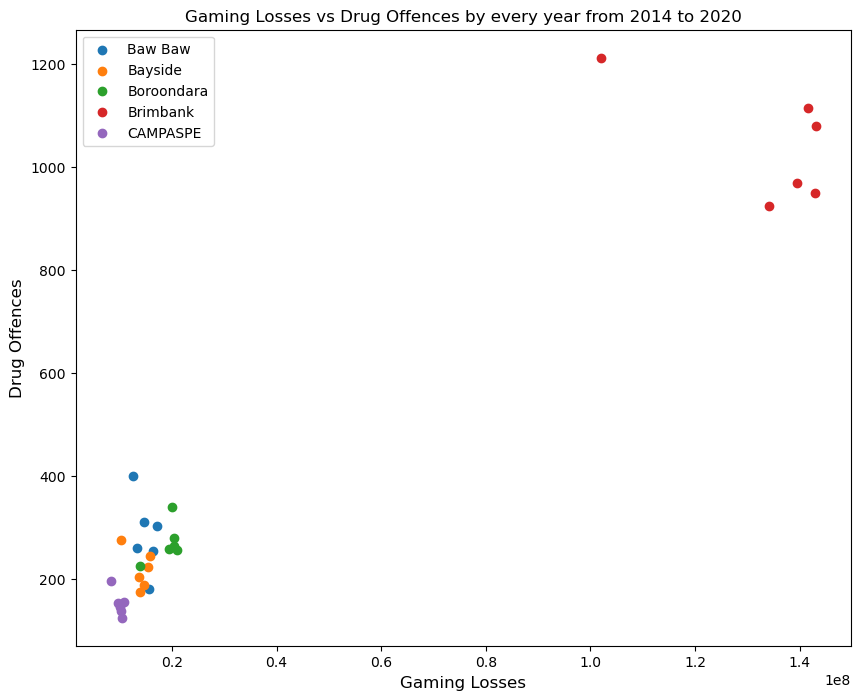

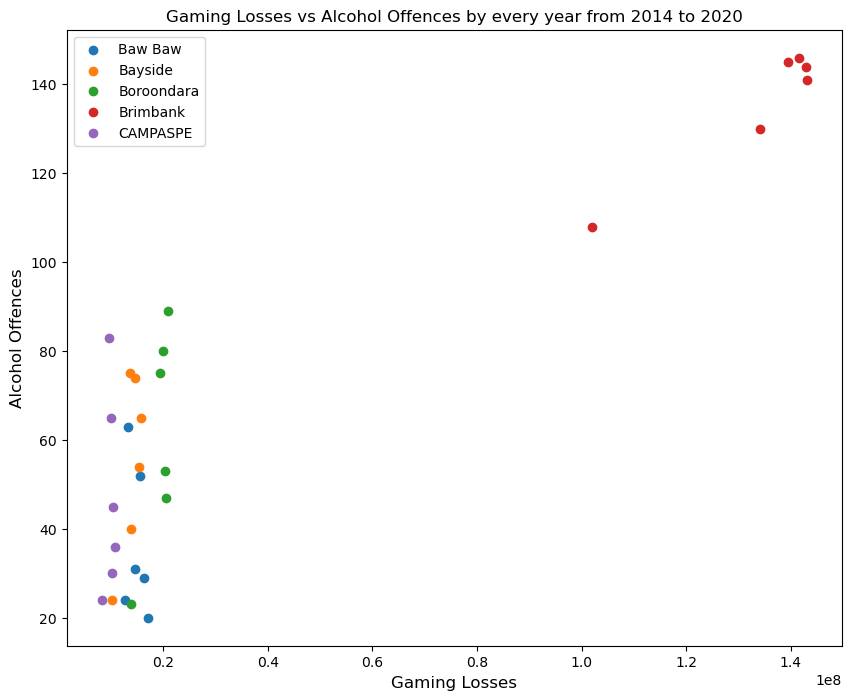

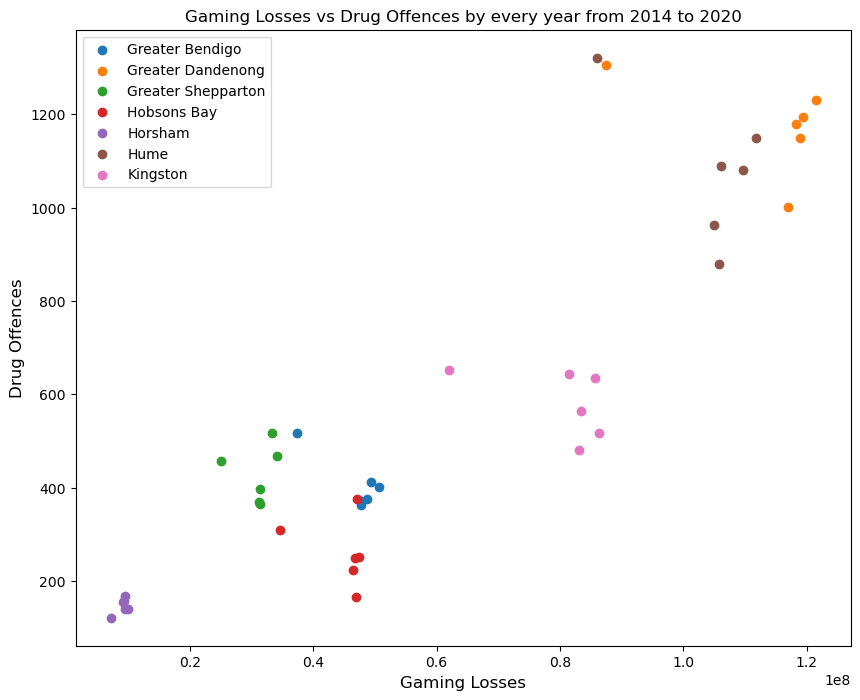

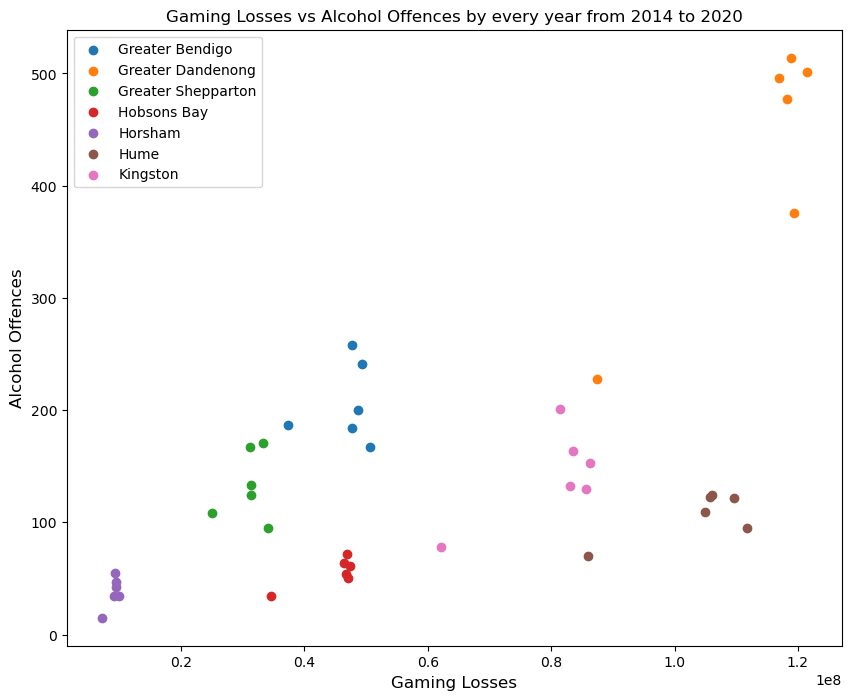

In [16]:
def egm_offence_scatter(start, end, offence_df, y_label):
    # Plot the data from "start" LGA (inclusive) to "end" LGA (exclusive)
    plt.figure(figsize=(10, 8))
    for i in range(start, end):
        # Extract gaming losses and offence data for each LGA
        gaming_losses = list(egm_df.iloc[i])[1:-1]  # Exclude first and last columns
        offences = list(offence_df.iloc[i])[1:-1]   # Exclude first and last columns
        
        # Plot scatter points for each LGA
        plt.scatter(gaming_losses, offences, label=offence_df.index[i])
    
    # Set labels and title
    plt.xlabel('Gaming Losses', fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.title(f"Gaming Losses vs {y_label} by every year from 2014 to 2020")
    plt.legend()

# Plot scatter graphs for different LGA ranges and offence types
egm_offence_scatter(5, 10, drug_offence_df, "Drug Offences")
egm_offence_scatter(5, 10, alcohol_offence_df, "Alcohol Offences")
egm_offence_scatter(20, 27, drug_offence_df, "Drug Offences")
egm_offence_scatter(20, 27, alcohol_offence_df, "Alcohol Offences")

In [17]:
# Function to calculate mean Pearson correlation coefficient
def calculate_mean_pear_corr(offence_df):
    total_corr = 0
    for i in range(57):
        # Calculate Pearson correlation for each LGA
        corr_coeff, p_value = pearsonr(list(egm_df.iloc[i]["2014": "2020"]), list(offence_df.iloc[i]["2014": "2020"]))
        total_corr += corr_coeff
    return total_corr / 57  # Return average correlation

# Calculate and print mean Pearson correlation for drug and alcohol offences
print(f"Mean EGM - Drug pearson corr from 2014 - 2020 of all 57 LGAs: {calculate_mean_pear_corr(drug_offence_df):.3f}")
print(f"Mean EGM - Alcohol pearson corr from 2014 - 2020 of all 57 LGAs: {calculate_mean_pear_corr(alcohol_offence_df):.3f}\n")

# Function to calculate mean Mutual Information
def calculate_mean_MI(offence_df):
    total_MI = 0
    for i in range(57):
        # Calculate Mutual Information for each LGA
        total_MI += mutual_info_regression(egm_df.iloc[i]["2014": "2020"].values.reshape(-1,1), offence_df.iloc[i]["2014": "2020"], discrete_features=False)[0]
    return total_MI / 57  # Return average Mutual Information

# Calculate and print mean Mutual Information for drug and alcohol offences
print(f"Mean EGM - Drug mutual information from 2014 - 2020 of all 57 LGAs: {calculate_mean_MI(drug_offence_df):.3f}")
print(f"Mean EGM - Alcohol mutual information from 2014 - 2020 of all 57 LGAs: {calculate_mean_MI(alcohol_offence_df):.3f}\n")

Mean EGM - Drug pearson corr from 2014 - 2020 of all 57 LGAs: -0.342
Mean EGM - Alcohol pearson corr from 2014 - 2020 of all 57 LGAs: 0.394

Mean EGM - Drug mutual information from 2014 - 2020 of all 57 LGAs: 0.078
Mean EGM - Alcohol mutual information from 2014 - 2020 of all 57 LGAs: 0.106



# **Machine Learning techniques**

**1. Supervised: Linear Regression**

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [19]:
egm_df.head()

,2014,2015,2016,2017,2018,2019,2020,Sum
Local Government Area,,,,,,,,
ALPINE,3119936.04,3120455.72,2517169.50,2571123.72,2457035.73,2304602.04,1892293.33,1.798262e+07
BENALLA,10150100.66,10059504.85,10804029.59,10078993.20,10824258.95,11077898.86,8887679.38,7.188247e+07
Ballarat,53642391.94,53623993.63,54611247.32,54568804.35,55763965.38,57540687.41,43713216.26,3.734643e+08
Banyule,55019402.31,54512648.72,55979946.78,55820854.07,58536906.89,57758108.75,42485587.54,3.801135e+08
Bass Coast,15087373.60,15851964.94,16321155.47,16126066.61,17675542.30,17616911.38,13044199.82,1.117232e+08


In [20]:
drug_and_alcohol_df.head()

Year,2014,2015,2016,2017,2018,2019,2020,Sum
Local Government Area,,,,,,,,
ALPINE,50.0,62.0,43.0,38.0,56.0,50.0,47.0,346.0
BENALLA,243.0,225.0,213.0,230.0,194.0,274.0,271.0,1650.0
Ballarat,727.0,530.0,528.0,420.0,452.0,416.0,375.0,3448.0
Banyule,350.0,418.0,421.0,361.0,474.0,540.0,720.0,3284.0
Bass Coast,169.0,221.0,129.0,138.0,137.0,131.0,133.0,1058.0


In [21]:
# Extract the sum of gaming losses and total offences
gaming_losses = egm_df["Sum"]
total_offences = drug_and_alcohol_df["Sum"]

# Reshape gaming losses into a 2D array (required for sklearn)
X = gaming_losses.values.reshape(-1, 1)
y = total_offences.values

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

# Create a Linear Regression model
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Print the predicted values
print("Predicted offence counts:")
print(y_pred)

Predicted offence counts:
[1850.77394352 2470.18495259 9079.66805548 1412.31942011 1382.19574344
 8477.69201935 2166.62713416 5125.04246772 2138.1411284  3006.41898251
 1624.81604638 8154.49688674]


In [22]:
# Evaluate the model using RMSE, MAE, and R² score
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R² Score: {r2}")

# Add explanatory comment
print("Note: RMSE is higher than MAE, which suggests the presence of outliers in the data.")

Root Mean Squared Error (RMSE): 1630.1075775079632
Mean Absolute Error (MAE): 1076.7666343021865
R² Score: 0.7038252271188814
Note: RMSE is higher than MAE, which suggests the presence of outliers in the data.


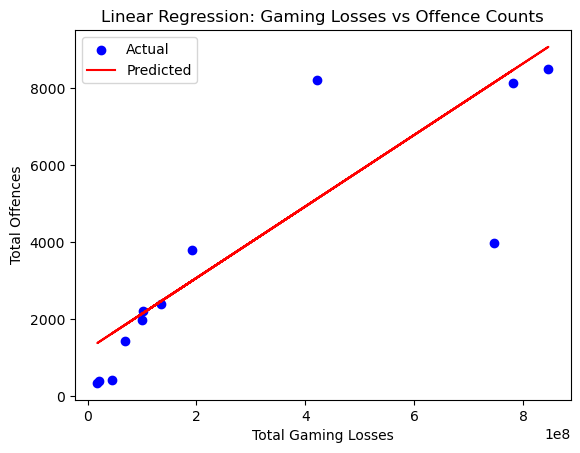

In [23]:
# Plot the results
plt.scatter(X_test, y_test, color='blue', label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=1.5, label='Predicted')
plt.xlabel('Total Gaming Losses')
plt.ylabel('Total Offences')
plt.title('Linear Regression: Gaming Losses vs Offence Counts')
plt.legend()
plt.show()

**2. Unsupervised: K-Means Clustering**

In [24]:
# Create new dataframe for clustering
# Combine gaming losses and offences data for each LGA
gaming_losses_sum = egm_df[["Sum"]]
offences_sum = drug_and_alcohol_df[["Sum"]]
cluster_df = pd.merge(gaming_losses_sum, offences_sum, left_index=True, right_index=True)

# Rename columns for clarity
cluster_df.columns = ['Gaming Losses', 'Offences']

# Display the first few rows of the new dataframe
cluster_df.head()

,Gaming Losses,Offences
Local Government Area,,
ALPINE,1.798262e+07,346.0
BENALLA,7.188247e+07,1650.0
Ballarat,3.734643e+08,3448.0
Banyule,3.801135e+08,3284.0
Bass Coast,1.117232e+08,1058.0


In [25]:
# Z-Score Normalization
# This step standardizes the 'Gaming Losses' and 'Offences' columns
# by subtracting the mean and dividing by the standard deviation.
# This ensures that both features are on the same scale for clustering.
scaler = StandardScaler()
cluster_df[['Normalized Gaming Losses', 'Normalized Offences']] = scaler.fit_transform(cluster_df[['Gaming Losses', 'Offences']])

In [26]:
cluster_df.head()

,Gaming Losses,Offences,Normalized Gaming Losses,Normalized Offences
Local Government Area,,,,
ALPINE,1.798262e+07,346.0,-1.163716,-0.949564
BENALLA,7.188247e+07,1650.0,-0.949110,-0.611552
Ballarat,3.734643e+08,3448.0,0.251662,-0.145490
Banyule,3.801135e+08,3284.0,0.278137,-0.188001
Bass Coast,1.117232e+08,1058.0,-0.790481,-0.765006


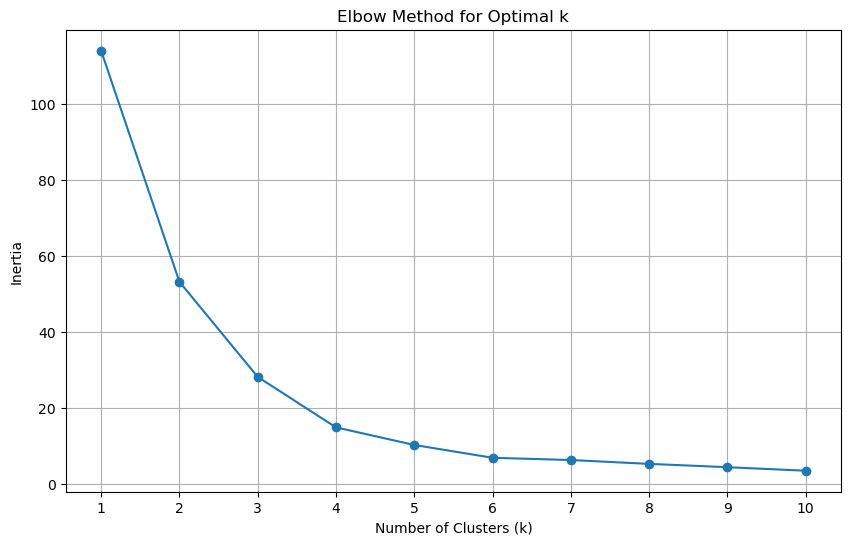

Percentage change from 1 to 2 clusters: 53.30%
Percentage change from 2 to 3 clusters: 46.97%
Percentage change from 3 to 4 clusters: 47.03%
Percentage change from 4 to 5 clusters: 30.92%
Percentage change from 5 to 6 clusters: 32.64%
Percentage change from 6 to 7 clusters: 8.50%
Percentage change from 7 to 8 clusters: 15.88%
Percentage change from 8 to 9 clusters: 16.28%
Percentage change from 9 to 10 clusters: 20.68%

Suggested optimal number of clusters: 7

Alternatively, consider using 2 clusters, which has the biggest percentage change.


In [30]:
# Addtional exploration, not in the scope of the study, not included in the report

# Elbow Method for K-means Clustering
# This method helps determine the optimal number of clusters by plotting the inertia (sum of squared distances)
# for different values of k (number of clusters). The goal is to find the 'elbow' point where the rate of
# decrease in inertia slows down, indicating a good balance between model complexity and fit.

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(cluster_df[['Gaming Losses', 'Offences']])

# Calculate inertia for different numbers of clusters
inertias = []
max_clusters = 10  # 10 seems to be enough

for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.grid(True)
plt.show()

# Calculate the percentage change in inertia
inertia_changes = np.diff(inertias) / np.array(inertias)[:-1] * 100

# Print the percentage changes
for k, change in enumerate(inertia_changes, start=2):
    print(f"Percentage change from {k-1} to {k} clusters: {abs(change):.2f}%")

# Find the optimal number of clusters
threshold = 20 
optimal_k = next((k for k, change in enumerate(inertia_changes, start=2) if abs(change) < threshold), None)

print(f"\nSuggested optimal number of clusters: {optimal_k}")

# If no clear elbow is found, you might want to choose based on the biggest percentage change
largest_change_k = np.argmax(np.abs(inertia_changes)) + 2
print(f"\nAlternatively, consider using {largest_change_k} clusters, which has the biggest percentage change.")

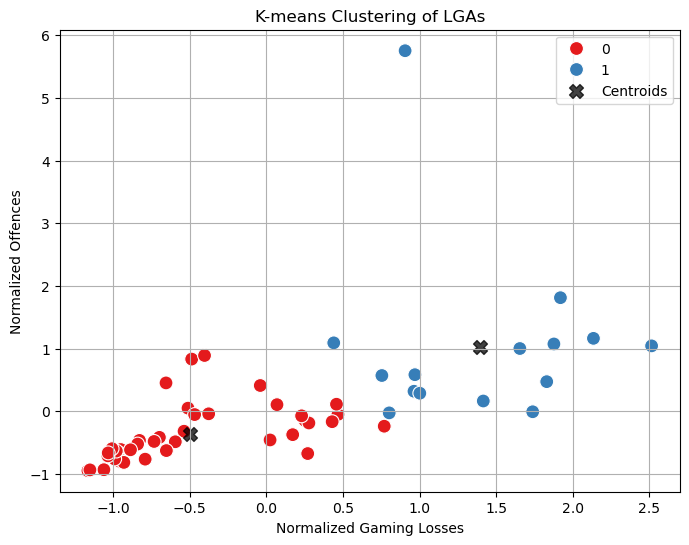

In [28]:
# K-means Clustering
# Initialize the KMeans model with 2 clusters 
kmeans = KMeans(n_clusters=2, random_state=56)

# Fit the model to the normalized data and assign cluster labels
cluster_df['Cluster Group'] = kmeans.fit_predict(cluster_df[['Normalized Gaming Losses', 'Normalized Offences']])

# Create a scatter plot to visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Normalized Gaming Losses', y='Normalized Offences', 
                hue='Cluster Group', data=cluster_df, palette='Set1', s=100)

# Set plot title and labels
plt.title('K-means Clustering of LGAs')
plt.xlabel('Normalized Gaming Losses')
plt.ylabel('Normalized Offences')

# Add centroids to the plot
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.75, marker='X', label='Centroids')

# Add legend and grid for better readability
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

# Note: This clustering separates LGAs into two groups based on their normalized gaming losses and offences.
# The centroids (marked with 'X') represent the average point of each cluster.

In [29]:
cluster_df["Cluster Group"]

Local Government Area
ALPINE                  0
BENALLA                 0
Ballarat                0
Banyule                 0
Bass Coast              0
Baw Baw                 0
Bayside                 0
Boroondara              0
Brimbank                1
CAMPASPE                0
CENTRAL GOLDFIELDS      0
COLAC-OTWAY             0
Cardinia                0
Casey                   1
Darebin                 1
East Gippsland          0
Frankston               1
GLENELG                 0
GREATER GEELONG         1
Glen Eira               0
Greater Bendigo         0
Greater Dandenong       1
Greater Shepparton      0
Hobsons Bay             0
Horsham                 0
Hume                    1
Kingston                1
Knox                    1
Latrobe                 0
MITCHELL                0
MOORABOOL               0
Macedon Ranges          0
Manningham              0
Maribyrnong             0
Maroondah               0
Melbourne               1
Melton                  0
Merri-bek       